In [ ]:
from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from skimage.segmentation import mark_boundaries
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
from skimage import io
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
import tensorflow.keras.layers as layers
from tensorflow.keras import backend as K
import tensorflow.keras.utils
import cv2
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras import utils as np_utils
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import *
from google.colab import drive
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.7 MB/s 


In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
def preprocess_images(images_arr, all_equal=True):
    global max_val, min_val
    if all_equal:
        images_arr = (images_arr-min_val)/(max_val-min_val)

    images_arr = images_arr*255
    mins = images_arr.min()
    maxs = images_arr.max()
    print(f'After normalization mins {mins}, maxs {maxs}')
    return images_arr, (mins, maxs)


max_val = 597.8047
min_val = -1606.5217

In [ ]:
def fscore_glass_and_consolidation(y_true, y_pred):
    return sm.metrics.f1_score(y_true[..., :2], 
                               y_pred[..., :2])  
    

In [ ]:
def plot_images(data, col = 4, colour_map = 'gray', img_size=6, title = 'Results',
                sub_title = ['Image', 'Ground_glass_mask', 'Pulmonary_consolidation_mask', 'Lung']):
    rows = 10
    fig = plt.figure(figsize=(col*img_size, rows*img_size))
    
    plt.suptitle(title, fontsize = 30)        
    for i, image_ in enumerate(data):
        fig.add_subplot(rows, col, i+1)
        plt.imshow(data[i], cmap=colour_map)
        plt.title(sub_title[i%col])
    plt.show()
    

In [ ]:
classification=keras.models.load_model('drive/MyDrive/Trained Models/xception', custom_objects=None)

Image 1 has COVID infection


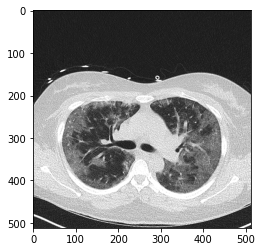

Image 2 has COVID infection


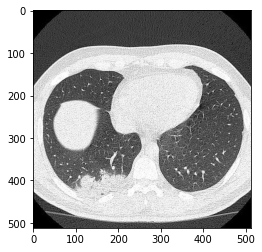

Image 3 has COVID infection


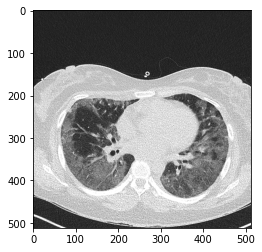

Image 4 has COVID infection


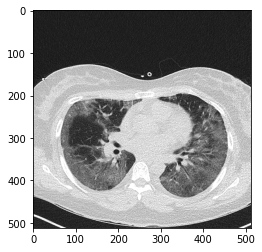

Image 5 has COVID infection


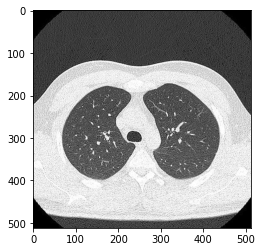

Image 6 has COVID infection


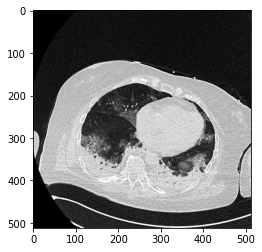

Image 7 has COVID infection


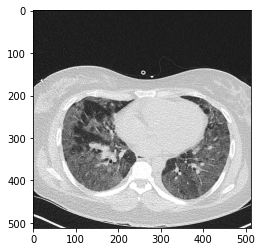

Image 8 has COVID infection


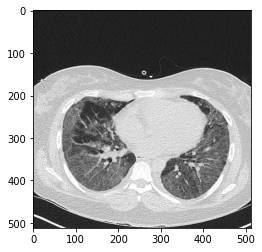

Image 9 has COVID infection


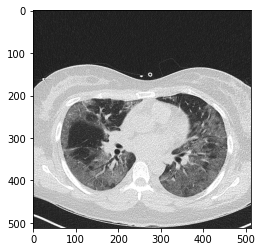

Image 10 has COVID infection


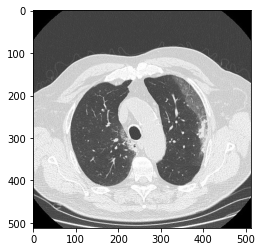

In [ ]:
arr = []
for i in range(1,11): 
  img=np.load('drive/My Drive/test/image'+str(i)+'.npy')
  pred_ind=np.argmax(classification.predict(np.expand_dims(img,axis=0))[0])
  #Only covid infected images will be used in segmentation
  if pred_ind == 1:
    print("Image " + str(i) + " has COVID infection")
    plt.imshow(np.squeeze(img).transpose(), cmap='gray')
    plt.show()
    arr.append(img)
  

In [ ]:
testData = np.stack(arr, axis=0)

In [ ]:
testData,_ = preprocess_images(testData)

After normalization mins 22.182680130004883, maxs 219.5130615234375


In [ ]:
segmentation = keras.models.load_model("/content/drive/MyDrive/covid_model_2.h5", custom_objects={'fscore_glass_and_consolidation': fscore_glass_and_consolidation})

In [ ]:
predLoad = segmentation.predict(testData, verbose=1)

1/1 [==============================] - 4s 4s/step


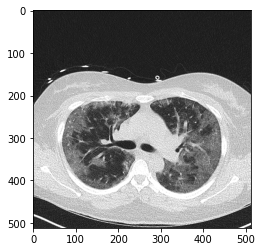


The percentage of lung involvement in Image 1:  36.72 % and the score is 3



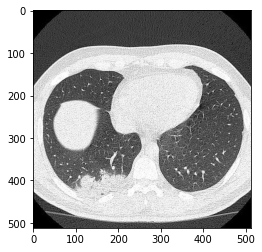


The percentage of lung involvement in Image 2:  14.63 % and the score is 2



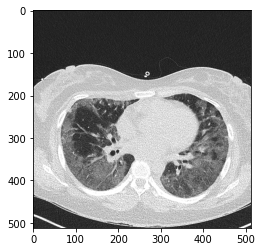


The percentage of lung involvement in Image 3:  38.39 % and the score is 3



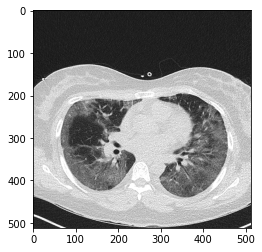


The percentage of lung involvement in Image 4:  42.28 % and the score is 3



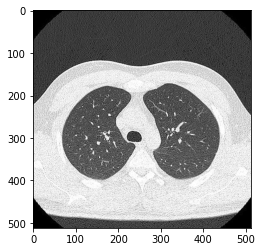


The percentage of lung involvement in Image 5:  1.75 % and the score is 1



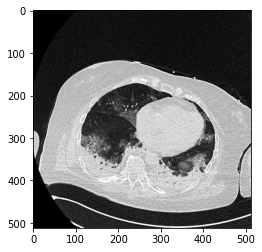


The percentage of lung involvement in Image 6:  32.39 % and the score is 3



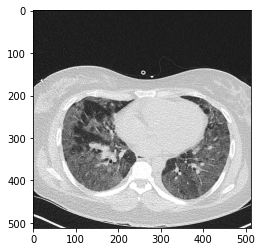


The percentage of lung involvement in Image 7:  47.62 % and the score is 3



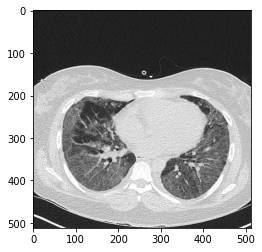


The percentage of lung involvement in Image 8:  48.27 % and the score is 3



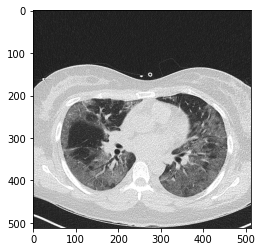


The percentage of lung involvement in Image 9:  43.82 % and the score is 3



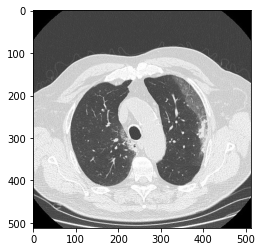


The percentage of lung involvement in Image 10:  8.74 % and the score is 2



In [ ]:
score=0
for ind in range(10):

  ggo=0
  conso=0
  lung=0
  for k in range(4):
    for i in range(512):
      for j in range(512):
        if predLoad[ind][i, j, k] >= 0.1:
          predLoad[ind][i, j, k] = 1
          if k == 0:
            ggo+=1
          if k == 1:
            conso+=1
          if k == 2:
            lung+=1
        else:
          predLoad[ind][i, j, k] = 0
  perc = (ggo+conso)/(ggo+conso+lung)
  perc = round(perc*100,2)
  if perc < 5:
    score=1
  elif perc>=5 and perc<=25:
    score=2
  elif perc>=26 and perc<=49:
    score=3
  elif perc>=50 and perc<=75:
    score=4
  else:
    score=5
  plt.imshow(np.squeeze(testData[ind,:,:,:]).transpose(), cmap='gray')
  plt.show()
  print()
  print("The percentage of lung involvement in Image " + str(ind+1) + ": ", str(perc), "% and the score is "+ str(score))
  print()

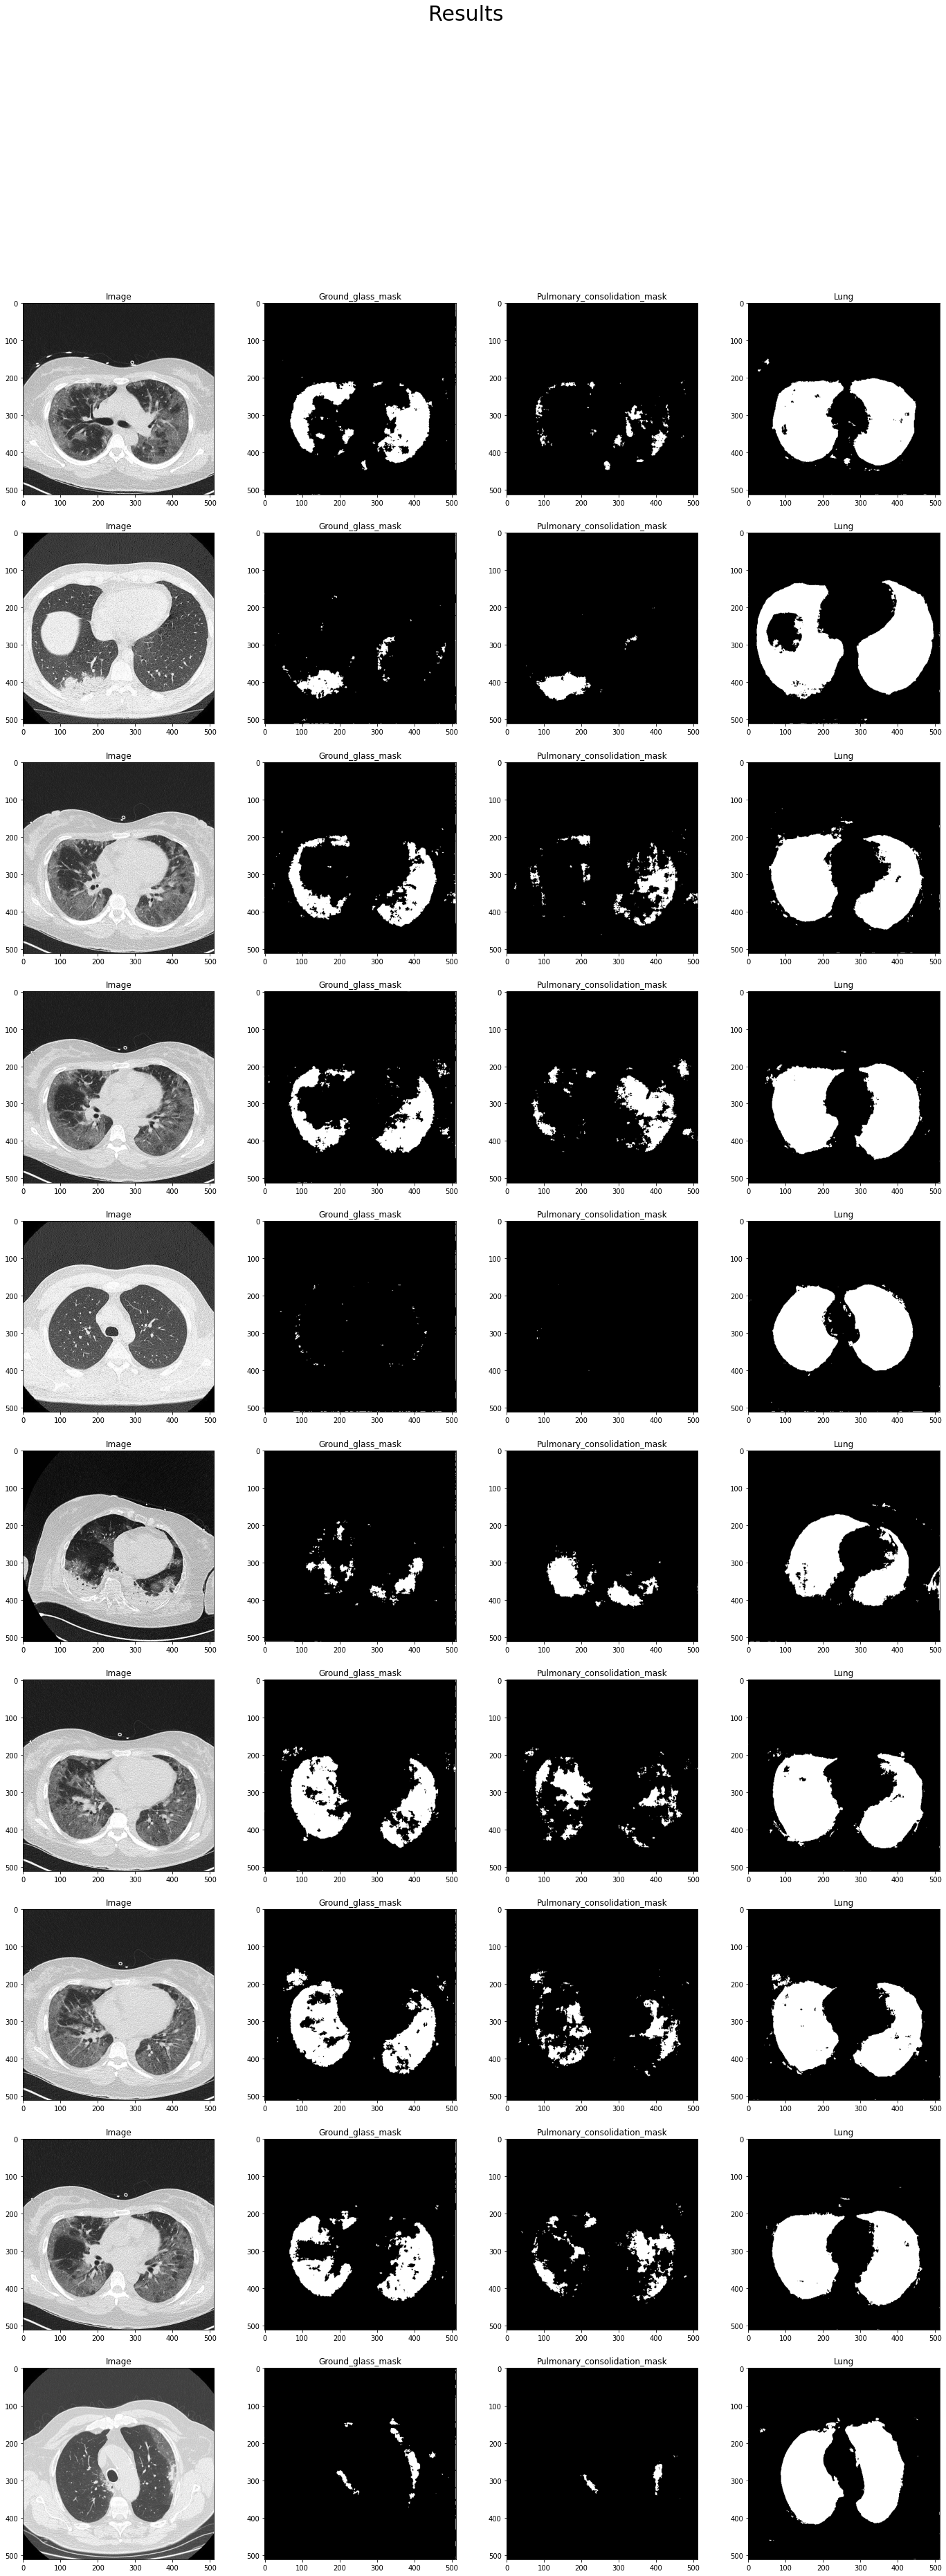

In [ ]:
plot_list = []    
for i in range(10):
    plot_list.append(testData[i].reshape(512,512).transpose())
    plot_list.append((predLoad[i][..., 0]*255).reshape(512,512).transpose())  # scale images between 0 and 255
    plot_list.append((predLoad[i][..., 1]*255).reshape(512,512).transpose())   # scale images between 0 and 255  
    plot_list.append((predLoad[i][..., 2]*255).reshape(512,512).transpose()) 

plot_images(plot_list)

In [ ]:
data_path= 'drive/MyDrive/normal' 
from google.colab.patches import cv2_imshow
selected_imgs_path=[]
for r,d,f in os.walk(data_path): 
  for file in f:
    if '.tif' in file:
      selected_imgs_path.append(os.path.join(r,file)) 


i=1
for img_name in selected_imgs_path: 
  img=cv2.imread(img_name,cv2.IMREAD_UNCHANGED) 
  pred_ind=np.argmax(classification.predict(np.expand_dims(np.expand_dims(img,axis=0),axis=3))[0])
  if pred_ind==0:
    #cv2_imshow(img)
    print("Image " + str(i) + " has no infection")
    i+=1

Image 1 has no infection
Image 2 has no infection
Image 3 has no infection
Image 4 has no infection
Image 5 has no infection
